# Libraries

In [19]:
import pandas as pd
import warnings
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import json
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Loading the processed Data

In [2]:
X_train = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/X_train.csv')
X_test = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/X_test.csv')
y_train = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/y_train.csv')['Class']
y_test = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/y_test.csv')['Class']

In [3]:
y_train = y_train.ravel()
y_test = y_test.ravel()

# Model

In [8]:
model = DecisionTreeClassifier(random_state=42)

In [9]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [10]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

In [11]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [12]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.9282051282051282


In [13]:
best_model = grid_search.best_estimator_

In [14]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [16]:
y_pred = best_model.predict(X_test)

# Evaluation

In [17]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [18]:
metrics = {
    'Accuracy': float(accuracy),
    'Precision': float(precision),
    'Recall': float(recall),
    'F1-score': float(f1),
    'True Positives': float(tp),
    'False Positives': float(fp)
}
with open('/Users/raya/Desktop/fraud-detection/european-dataset/reports/decision_tree/metrics.json', 'w') as f:
    json.dump(metrics, f,indent=4)

pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(30).to_csv('/Users/raya/Desktop/fraud-detection/european-dataset/reports/decision_tree/results.csv')

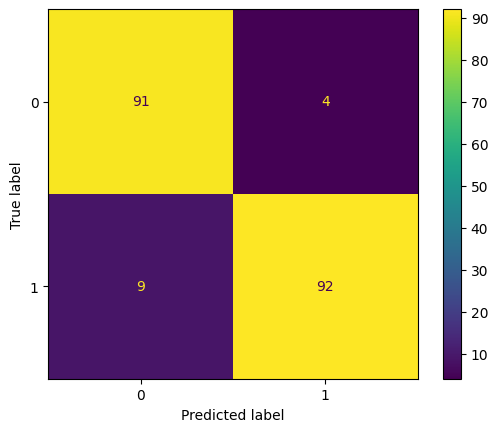

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
